In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

In [2]:
#generate the sample
def gen_data():
    nobs = 1000
    beta = 3
    x = np.random.uniform(low=-3., high=3., size=nobs)
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1*(1 + beta * x + e >= 0) 
    return y,x,nobs

In [3]:
def compute_llr(yn,xn):
    
    model1 = sm.Probit(yn,sm.add_constant(xn))
    model1_fit = model1.fit(disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    
    model2 = sm.Logit(yn,sm.add_constant(xn))
    model2_fit = model2.fit(disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    
    llr = ll1.sum() - ll2.sum()
    omega2 = (ll1- ll2).var()
    return llr,np.sqrt(omega2)


yn,xn,nobs = gen_data()
print(compute_llr(yn,xn))

(-0.19554192571766293, 0.02319395978060916)


(False, False)


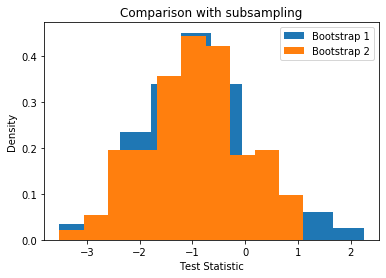

In [4]:
def regular_test(yn,xn,nobs,hist=False):
    llr, omega = compute_llr(yn,xn)
    test_stat = llr/(omega*np.sqrt(nobs))
    #plot
    if hist:
        x = np.linspace(-2.5, 2.5, 100)
        plt.plot(x, stats.norm.pdf(x, 0, 1),label="Normal")
    
    return np.abs(test_stat) >= 1.96


def bootstrap_test(yn,xn,nobs,hist=False):
    llrs = []
    omegas = []
    trials = 200
    subn = 1000
    
    for i in range(trials):
        
        np.random.seed()
        sample  = np.random.choice(np.arange(0,nobs),subn,replace=True)
        ys,xs = yn[sample],xn[sample]
        llr, omega = compute_llr(ys,xs)
        llrs.append(llr)
        omegas.append(omega)
    
    llr, omega = compute_llr(yn,xn)
    
    test_stat1 =np.array(llrs)/(np.array(omegas)*np.sqrt(subn))
    test_stat2 = np.array(llrs)/(omega*np.sqrt(subn))
    
    #plot
    if hist:
        plt.hist(test_stat1, density=True,bins=10, label="Bootstrap 1")
        plt.hist(test_stat2, density=True,bins=10, label="Bootstrap 2")
    
    cv_upper1 = np.percentile(test_stat1, 97.5, axis=0)
    cv_lower1 = np.percentile(test_stat1, 2.5, axis=0)
    
    cv_upper2 = np.percentile(test_stat2, 97.5, axis=0)
    cv_lower2 = np.percentile(test_stat2, 2.5, axis=0)
    
    test_stat = llr/(omega*np.sqrt(nobs))
    return 0 >= cv_upper1 or 0 <= cv_lower1, 0 >= cv_upper2 or 0 <= cv_lower2
    

yn,xn,nobs = gen_data()
print(bootstrap_test(yn,xn,nobs,hist=True))

plt.title("Comparison with subsampling")
plt.xlabel("Test Statistic")
plt.ylabel("Density")
plt.legend()
plt.savefig('figs/bootstrap_compare')
plt.show()

In [5]:
reg = 0
boot1 = 0 
boot2 = 0 
total = 100
for i in range(total):
    np.random.seed()
    yn,xn,nobs = gen_data()
    reg = regular_test(yn,xn,nobs) +reg
    
    boot_result = bootstrap_test(yn,xn,nobs)
    boot1 = boot_result[0] + boot1
    boot2 = boot_result[1] + boot2

print("reg: %s, boot1: %s, boot2: %s"%(reg/total,boot1/total,boot2/total))

reg: 0.26, boot1: 0.26, boot2: 0.26
